#### 1Q. Perform morphological operations to remove both connected lines in ‘test 2.bmp’ to produce only four isolated objects as shown below. 

([], [])

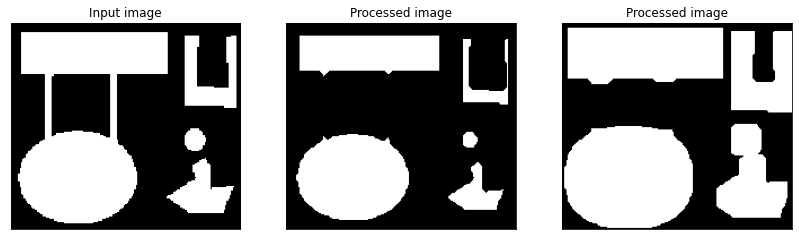

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

def convert_rgb(img):
    imgg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return imgg

# Reading an image in default mode  
image = cv2.imread(r'test 2.bmp')

# Window name in which image is displayed  
window_name = 'Image'
  
# Creating kernel (Structing Element) 

#kernel = np.array([[0,1,0],[1, 1, 1],[0, 1, 0]], dtype=np.uint8)*255

kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

kernel2=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

#YOUR CODE STARTS HERE

# Call the cv2.erode() method with appropriate parameters
img_erode = cv2.erode(image,kernel, iterations=3) 


# Call the cv2.dilate() method with appropriate parameters  
img_dilate = cv2.dilate(img_erode, kernel2, iterations=7)

# Displaying the image 
plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
img1=convert_rgb(image)
plt.imshow(img1)
plt.title('Input image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
img2=convert_rgb(img_erode)
plt.imshow(img_erode)
plt.title('Processed image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
img2=convert_rgb(img_dilate)
plt.imshow(img_dilate)
plt.title('Processed image')
plt.xticks([])
plt.yticks([])
  


#### 2Q. Implement a Hough Transform method for finding lines (you can use the inbuilt edge operator functions). Note that the coordinate system used is as pictured below with the origin placed one pixel above and to the left of the upper-left pixel of the image and with the Y-axis pointing downwards.Thus, the pixel at img(r,c) corresponds to the (x,y) coordinates (r,c), i.e. x=c and y=r. This pixel should vote for line parameters (ρ,θ) where: ρ = x⋅cos(θ) + y⋅sin(θ), and θ = atan2(y,x). This has the effect of making the positive angular direction clockwise instead of counter-clockwise in the usual convention. Theta (θ) = zero still points in the direction of the positive X-axis. 
<br>a) Write a function hough_lines_acc that computes the Hough Transform for lines and produces an accumulator array. Your code should try to conform to the specifications of the hough function in Matlab: http://www.mathworks.com/help/images/ref/hough.html Note that it has also two optional parameters RhoResolution and Theta, and returns three values - the hough accumulator array H, theta (θ) values that correspond to columns of H and rho (ρ) values that correspond to rows of H.
You can apply it to the edge image (img_edges) of ‘ps1.png’ as: 
	[H, theta, rho] = hough_lines_acc(img_edges); 
Or, with one optional parameter specified (θ = integers -90 to 89, i.e. 180 values including 0):
 	[H, theta, rho] = hough_lines_acc(img_edges, 'Theta', -90:89);
<br>b) Write a function hough_peaks that finds indices of the accumulator array (here line parameters) that correspond to local maxima. Your code should try to conform to the specifications of the Matlab function houghpeaks: http://www.mathworks.com/help/images/ref/houghpeaks.html 
Note that you need to return a Qx2 matrix with row indices (here rho) in column 1, and column indices (here theta) in column 2. (This could be used for other peak finding purposes as well.) Call your function with the accumulator from the step above to find up to 10 strongest lines: 
	peaks = hough_peaks(H, 10);
<br> c) Write a function hough_lines_draw  to draw color lines that correspond to peaks found in the accumulator array. This means you need to look up rho, theta values using the peak indices, and then convert them (back) to line parameters in cartesian coordinates (you can then use regular line-drawing functions). Use this to draw lines on the original grayscale (not edge) image. The lines should extend to the edges of the image (aka infinite lines).

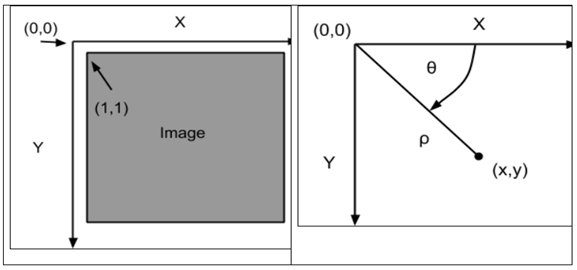

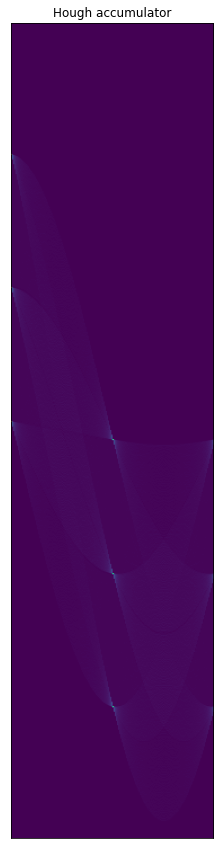

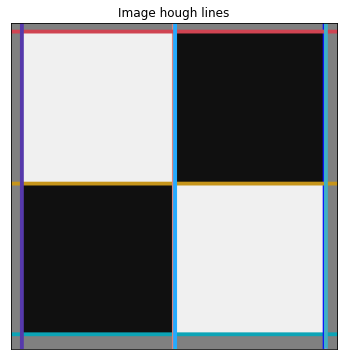

In [14]:
import numpy as np 
import math
import cv2
import random

#Returns hough_accumulator array
def hough_lines_acc(img_edges):
    #Init
    angle_step=1
    diagonal_length=int((img_edges.shape[0]**2+img_edges.shape[1]**2)**(0.5))

    #Array of rhos of length twice of diagonal ranging from -d to +d
    rhos = np.linspace(-diagonal_length, diagonal_length, diagonal_length * 2)

    #Array of thetas .Here angle step determines the number of thetas 
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))

    #Caching some reusable theta values in cos_t and sin_t 
    cos_t=np.cos(thetas)
    sin_t=np.sin(thetas)
    num_thetas=len(thetas)

    #Hough Accumulator Array with dimension 2d * no_of_thetas
    hough_accumulator = np.zeros((2*diagonal_length,num_thetas),np.uint8)

    #Catching indices of non zero pixels
    y_idxs, x_idxs = np.nonzero(img_edges)
    for i in range(len(x_idxs)):
        x=x_idxs[i]
        y=y_idxs[i]
        for j in range(num_thetas):
            #Computing rho for indexing in accumulator array.Here I added diagonal_length as indices can't be negative
            rho=diagonal_length + int(round(x*cos_t[j] + y*sin_t[j]))
            hough_accumulator[rho,j]+=1

    return hough_accumulator,thetas,rhos

#Performs peak detection in hough accumulator array
def hough_peaks(accumulator_array):
    arr=[]
    
    #arr will store the indices alongwith corresponding values at those indices 
    row=accumulator_array.shape[0]
    col=accumulator_array.shape[1]
    for i in range(0,row):
        for j in range(0,col):
            arr.append([i,j,accumulator_array[i,j]])
    
    #Sorting arr with respect to accumulator array counts
    arr.sort(key=lambda x: x[2],reverse=True)
    peaks_idx=np.zeros([10,2],np.uint32)

    #storing indices of first 10 peaks in peaks_idx
    for k in range(0,10):
        a=arr[k][0]
        b=arr[k][1]
        peaks_idx[k][0]=a
        peaks_idx[k][1]=b

    return peaks_idx

#Draws hough lines on the original image
def hough_lines_draw(img,peaks_idx,rhos,thetas):
    diagonal_length=int((img.shape[0]**2+img.shape[1]**2)**(0.5))
    row=img.shape[0]
    col=img.shape[1]
    for i in range(0,10):
        x=0
        y=0
        rho_idx=peaks_idx[i][0]
        theta=peaks_idx[i][1]
        rho=rhos[rho_idx]

        if math.cos(theta)!=0 :
            x=int(rho/math.cos(math.radians(theta)))
        if math.sin(theta)!=0 :
            y=int(rho/math.sin(math.radians(theta)))

        if int(math.cos(math.radians(theta)))==0 :
            a=abs(int(rho))
            b=row
            c=abs(int(rho))
            d=y-diagonal_length
        elif math.sin(math.radians(theta))==0 :
            a=x
            b=abs(int(rho))
            c=col
            d=abs(int(rho))
        else:
            a=0
            b=x
            c=y
            d=0
        
        #Random color generator
        color = list(np.random.random(size=3) * 256)
        cv2.line(img, (a,b), (c,d), color, 2)
    #Displaying image with hough lines    
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title('Image hough lines')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
img=cv2.imread(r'ps1.png',0)
imgrgb=cv2.imread(r'ps1.png',1)

#Perform inbuilt canny edge detection
img_edges=cv2.Canny(img,100,200)

hough_accumulator,thetas,rhos=hough_lines_acc(img_edges)

#Display hough_accumulator array
plt.figure(figsize=(6,15))
plt.imshow(hough_accumulator)
plt.title('Hough accumulator')
plt.xticks([])
plt.yticks([])
plt.show()

peaks_idx=hough_peaks(hough_accumulator)
hough_lines_draw(imgrgb,peaks_idx,rhos,thetas)

#### 3Q. Write a program to detect corners in the given image with Harris Corner Detection method.

([], [])

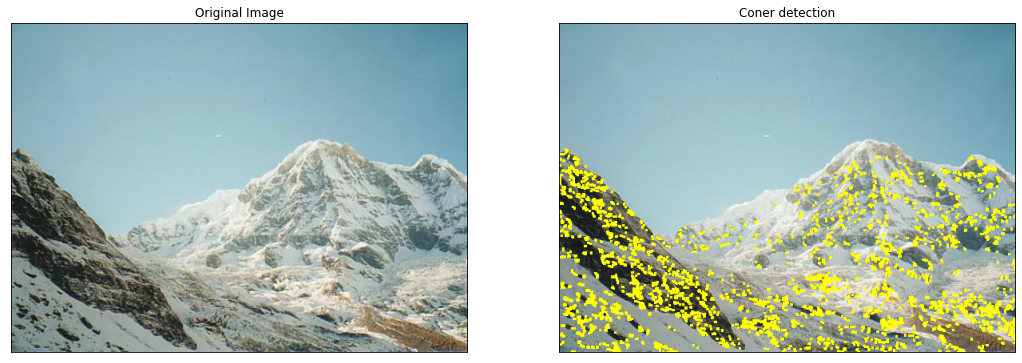

In [5]:

# Python programe to illustrate
# corner detection with
# Harris Corner Detection Method
  
# organizing imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_rgb(img):
    imgg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return imgg

  
# path to input image specified and 
# image is loaded with imread command
image = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\match_left.png')
imagec= image.copy()
  
# convert the input image into
# grayscale color space
operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
# modify the data type
# setting to 32-bit floating point
operatedImage = np.float32(operatedImage)
  
# apply the cv2.cornerHarris method
# to detect the corners with appropriate
# values as input parameters
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)
  
# Results are marked through the dilated corners
dest = cv2.dilate(dest, None)
  
# Reverting back to the original image,
# with optimal threshold value
imagec[dest > 0.01 * dest.max()]=[0, 255, 255]
  

plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
img1=convert_rgb(image)
plt.imshow(img1)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
img2=convert_rgb(imagec)
plt.imshow(img2)
plt.title('Coner detection')
plt.xticks([])
plt.yticks([])


#### 4Q. Write a program to perform image stitching for two images. Use SIFT features and homography based Feature Matching technique. Use match_left.png and match_right.png to test the program. NOTE: install "pip install opencv-contrib-python" to use builtin SIFT descriptor.

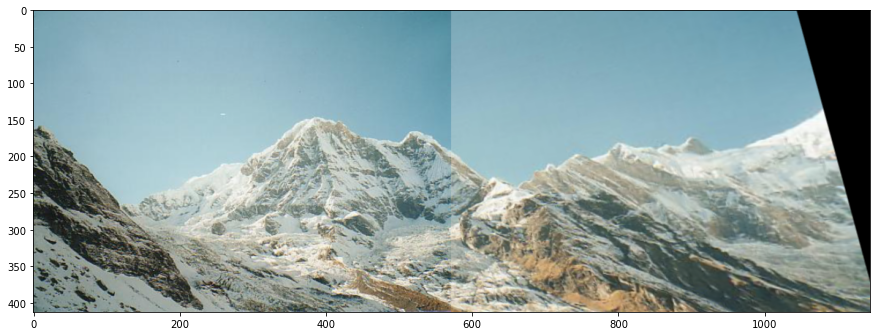

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
"""
Steps:
1. Compute the sift-key points and descriptors for left and right images.
2. Compute distances between every descriptor in one image and every descriptor in the other image.
3. Select the top best matches for each descriptor of an image.
4. Run RANSAC to estimate homography.
5. Warp to align for stitching.
6. Finally stitch them together.
"""
#import two images and convert them to grayscale. If image sizes is large resize them
img_ = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\match_right.png')
img_ = cv2.resize(img_, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)

img = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\match_left.png')
img = cv2.resize(img, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#YOUR CODE STARTS HERE

#Find out the SIFT features in both images.
sift=cv2.xfeatures2d.SIFT_create()


# find the key points and descriptors with SIFT
kp1,des1=sift.detectAndCompute(img1,None)
kp2,des2=sift.detectAndCompute(img2,None)

cv2.imshow('original_image_right_keypoints',cv2.drawKeypoints(img_,kp1,None))
cv2.imshow('original_image_left_keypoints',cv2.drawKeypoints(img,kp2,None))
cv2.waitKey(0)

#feature matching using cv2.BFMatcher()
bf=cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches=bf.match(des1,des2)
 
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], img2, flags=2)

cv2.imshow("original_image_draw_Good_Matches.jpg", img3)
cv2.waitKey(0)

cv2.destroyAllWindows()

#calculate the homography matrix and use RANSAC to remove outliers.
#the homography matrix will be used with best matching points, 
# to estimate a relative orientation transformation within the two images.
# Swap image inputs. So "img_" now will take right image and "img" will take left image.
MIN_MATCH_COUNT = 10
if len(matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    #find the homography matrix and use RANSAC to remove outliers.
    (M, status) = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    #find perspectiveTransform
    #dst = 
    #img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    cv2.imshow("original_image_overlapping.jpg", img2)
    cv2.waitKey(0)
else:
    print ("Not enough matches are found - %d/%d" % (len(matches),MIN_MATCH_COUNT))

    #YOUR CODE ENDS HERE
    
#warp perspective projections of the image
dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img
cv2.imshow("original_image_stitched.jpg", dst)
cv2.waitKey(0)

plt.figure(figsize=(15, 15))
dst=cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)
plt.imshow(dst)


cv2.destroyAllWindows()

#### 5Q. Write a program to detect green colour form the given image.

([], [])

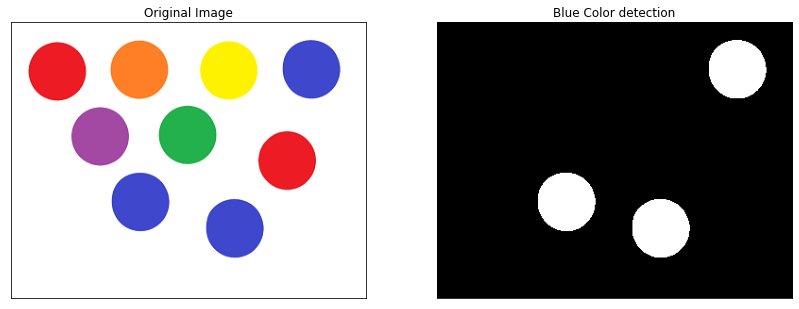

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_rgb(img):
    imgg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return imgg

img = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\circles.png')

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
masking = cv2.inRange(hsv_img, lower_blue, upper_blue)


# Displaying the image 
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
img1=convert_rgb(img)
plt.imshow(img1)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
img2=convert_rgb(masking)
plt.imshow(img2)
plt.title('Blue Color detection')
plt.xticks([])
plt.yticks([])


#### 6Q. Write a program to threshold the given image using Otsu's segmentation.

Otsu's algorithm implementation thresholding result:  132.4453125
Obtained threshold:  133.0


([], [])

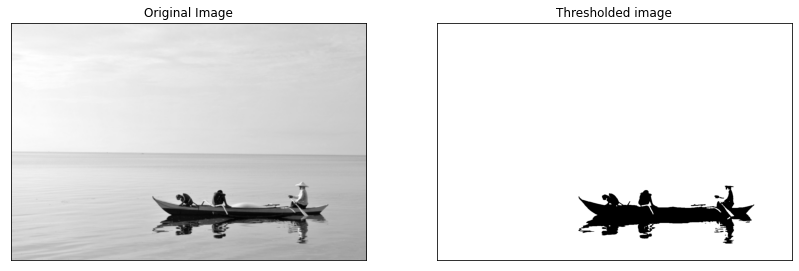

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_rgb(img):
    imgg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return imgg

# Read the image in a grayscale mode
image = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\boat.jpg', 0)

# Apply GaussianBlur to reduce image noise if it is required
image = cv2.GaussianBlur(image, (5, 5), 0)

# Set total number of bins in the histogram
bins_num = 256
# Get the image histogram
hist, bin_edges = np.histogram(image, bins=bins_num)

# Get normalized histogram if it is required
hist = np.divide(hist.ravel(), hist.max())

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1

# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)
threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

# Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
# Use a bimodal image as an input.
# Optimal threshold value is determined automatically.
otsu_threshold, image_result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Obtained threshold: ", otsu_threshold)

# Displaying the image 
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
img1=convert_rgb(image)
plt.imshow(img1)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
img2=convert_rgb(image_result)
plt.imshow(img2)
plt.title('Thresholded image')
plt.xticks([])
plt.yticks([])


#### 7Q. Implement k-means cluter based segmentation for gray scale images.Compare the segmentation outputs for different k values (k=2,3). Use scene.jpeg to test your code.

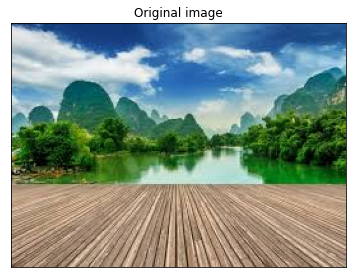

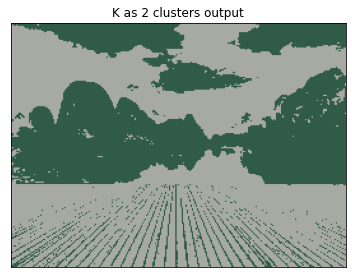

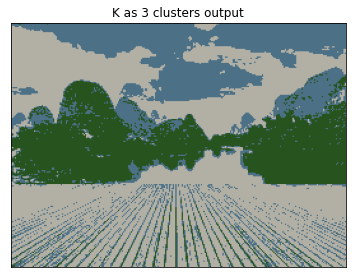

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#YOUR CODE STARTS HERE
# Read in the image 
image = cv2.imread(r'E:\VNIT Stuff\CV_S21\CSL442_IVP_S21_Programming_Assignment-2\scene.jpeg') 
  
# Change color to RGB (from BGR) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  
#display images
plt.figure(figsize=(6,6))
plt.title("Original image")
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

# Reshaping the image into a 2D array of pixels and 3 color values (RGB) 
pixel_vals = image.reshape((-1,3)) 
  
# Convert to float type 
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
  

k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
  
# convert data into 8-bit values 
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()] 
  
# reshape data into the original image dimensions 
segmented_image = segmented_data.reshape((image.shape)) 

#display images
plt.figure(figsize=(6,6))
plt.title("K as 2 clusters output")
plt.imshow(segmented_image)
plt.xticks([])
plt.yticks([])
plt.show()

#Now if we change the value of k to 3, we get the following Output:
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
  
# convert data into 8-bit values 
centers = np.uint8(centers) 
segmented_data1 = centers[labels.flatten()] 
  
# reshape data into the original image dimensions 
segmented_image1 = segmented_data1.reshape((image.shape)) 

#display images
plt.figure(figsize=(6,6))
plt.title("K as 3 clusters output")
plt.imshow(segmented_image1)
plt.xticks([])
plt.yticks([])
plt.show()

#YOUR CODE ENDS HERE

In [ ]:
# window_size = 2
# offset = 0
# k = 0.05

# for y in range(offset, height-offset):
#     for x in range(offset, width-offset):
#         Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
#         Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
#         Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

#         #Finding the determinant and trace, to get corner response
#         det = (Sxx * Syy) - (Sxy**2)
#         trace = Sxx + Syy
#         r = det - k*(trace**2)
#         if r > 100000:
#             # this is a corner
#             img_copy_for_corners[y,x] = [0,0,255]
